In [1]:
%matplotlib notebook

import sys
import os
import time
from importlib import reload

import numpy as npg
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc
import broadbean as bb
from broadbean.plotting import plotter

In [3]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

# Init instruments

## Create instruments

In [4]:
inst_list = []

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9870; reload(ATS9870)
from qcodes.instrument_drivers.AlazarTech.ATS9870 import AlazarTech_ATS9870
alazar = instools.create_inst(AlazarTech_ATS9870, 'alazar', force_new_instance=True)
inst_list.append(alazar)

# Alazar aquisition controllers
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl
raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20", force_new_instance=True)
inst_list.append(LO)

RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.29.172", force_new_instance=True)
inst_list.append(RF)

from pytopo.rf.sources import HeterodyneSource
hetsrc = instools.create_inst(HeterodyneSource, 'hetsrc', RF=RF, LO=LO, force_new_instance=True)
inst_list.append(hetsrc)

station = qc.Station(*inst_list)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110435, firmware:3.1.19.15-3.50.124.67) in 0.06s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110433, firmware:3.1.19.15-3.50.124.67) in 0.03s


## Default instrument settings

In [18]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(1e9)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(0.1)
    alazar.channel_range2(0.1)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('CHANNEL_A')
    alazar.trigger_level1(128 + 10)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_1V')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e7))
    
    
hetsrc.frequency(5e9)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:522: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


In [19]:
raw_acq.update_acquisitionkwargs(
    samples_per_record=128*10,
    records_per_buffer=1,
    buffers_per_acquisition=1,
)
data = raw_acq.acquisition()

<IPython.core.display.Javascript object>


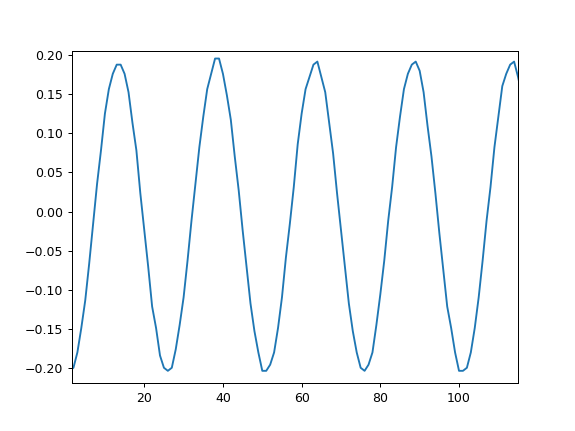

In [24]:
fig, (ax, bx) = plt.subplots(2, 1)

ax.plot(data[0, 0, :, 0])

In [33]:
data2 = data.reshape(1, 1280*2)
data3 = data.reshape(1, 2, 1280)

<IPython.core.display.Javascript object>


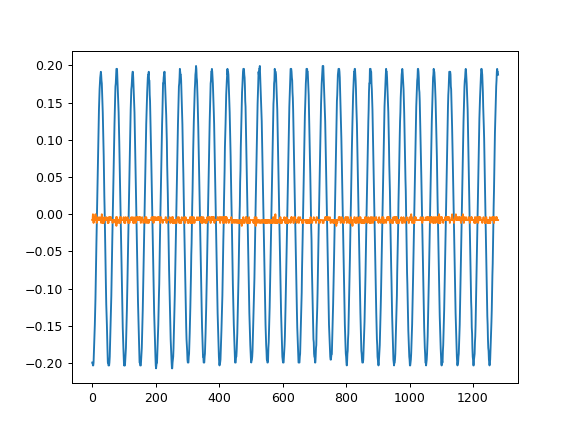

In [36]:
fig, ax = plt.subplots(1, 1)

ax.plot(data3[0, 0, :])
ax.plot(data3[0, 1, :])

In [38]:
alazar.IDN()

{'firmware': None,
 'model': 'ATS9870',
 'max_samples': 4294966272,
 'bits_per_sample': 8,
 'serial': '910323',
 'vendor': 'AlazarTech',
 'CPLD_version': '13.8',
 'driver_version': '5.10.15',
 'SDK_version': '5.10.15',
 'latest_cal_date': '29-05-13',
 'memory_size': '4294966272',
 'asopc_type': '2435577968',
 'pcie_link_speed': '0.25GB/s',
 'pcie_link_width': '8'}